In [1]:
#%%capture
from pyicecake import pyicecake
import types
import collections
import numpy as np
from random import shuffle
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types
import PIL
from PIL import Image

In [2]:
gc = pyicecake.GPUCache(40*1024*1024*1024) # 60GB

In [3]:
labels_dict = dict()
filenames = []
def convert_image_to_dltensor(image_folder):
    files = []
#     with open(image_folder + 'val.txt', 'r') as f:
    with open(image_folder + 'file_list.txt', 'r') as f:
        files = [line.strip() for line in f if line is not '']
    for l in files:
        filename = l.split(' ')[0]
        filenames.append(filename)
        npbuff = np.asarray(PIL.Image.open(image_folder+filename), dtype=np.uint8)
        gc.put_numpy_array(filename, npbuff)

In [4]:
# convert_image_to_dltensor('/mnt/optane-ssd/lipeng/imagenet/')
convert_image_to_dltensor('/home/lwangay/dali-data/images/')

for f in filenames[:10]:
    print(f)

dog/dog_1.jpg
dog/dog_2.jpg
dog/dog_3.jpg
dog/dog_4.jpg
dog/dog_5.jpg
dog/dog_6.jpg
dog/dog_7.jpg
dog/dog_8.jpg
dog/dog_9.jpg
dog/dog_10.jpg


In [5]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline
def show_all_imgs(imgs):
    _, axs = plt.subplots(5, 4, figsize=(12, 12))
    axs = axs.flatten()
    for img, ax in zip(imgs, axs):
        ax.imshow(img)
    plt.show()

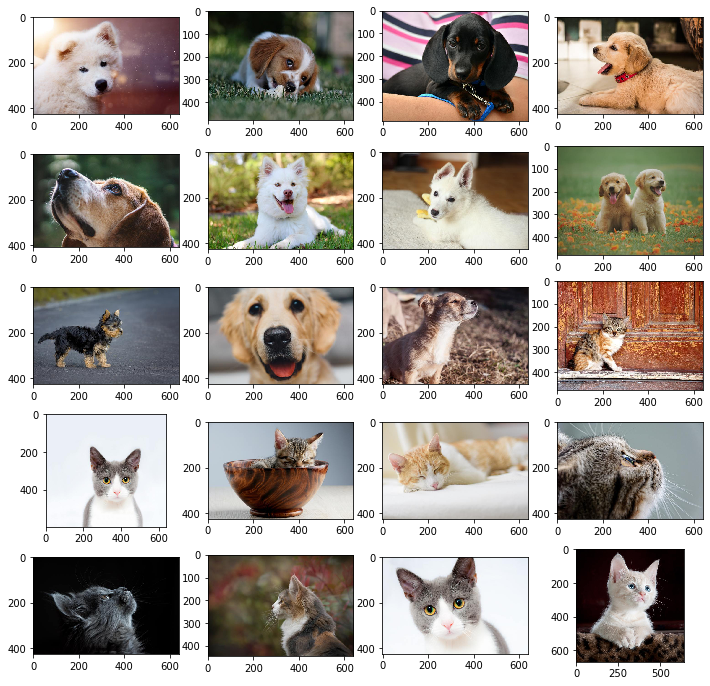

In [6]:
imgs = []
for f in filenames[:20]:
    npbuff = gc.get_numpy_array(f)
    img = PIL.Image.fromarray(npbuff)
    imgs.append(img)
show_all_imgs(imgs)
    



In [7]:
batch_size=64

In [8]:
class ExternalInputIterator(object):
    def __init__(self, batch_size):
        self.batch_size = batch_size
        self.files = filenames

    def __iter__(self):
        self.i = 0
        self.n = len(self.files)
        return self

    def __next__(self):
        batch = []
        labels = []
        for _ in range(self.batch_size):
            batch.append(filenames[self.i])
            self.i = (self.i + 1) % self.n
        return batch

    next = __next__

In [9]:
eii = ExternalInputIterator(batch_size)
iterator = iter(eii)

In [10]:
def read_from_icecake():
    ret = iterator.next()
    dltensors = []
    for f in ret:
#         print(f)
        dltensors.append(gc.get_dltensor(f, 0))
    return dltensors

class ExternalSourcePipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(ExternalSourcePipeline, self).__init__(batch_size,num_threads,device_id,exec_async=False,
                                             exec_pipelined=False,seed=12)
        self.read_from_icecake = ops.DLTensorPythonFunction(function=read_from_icecake, device='gpu', 
                                              synchronize_stream=True, batch_processing=True)
#         self.rotate = ops.Rotate(device='gpu')
#         self.rng = ops.Uniform(range = (-30.0, 30.0))
#         self.crop = ops.RandomResizedCrop(device='gpu', size=[200,200])
    def define_graph(self):
        res = self.read_from_icecake()
#         res = self.crop(res)
#         angle = self.rng()
#         res = self.rotate(res, angle=angle)
        return res



In [11]:
pipe = ExternalSourcePipeline(batch_size=batch_size, num_threads=2, device_id = 0)
pipe.build()

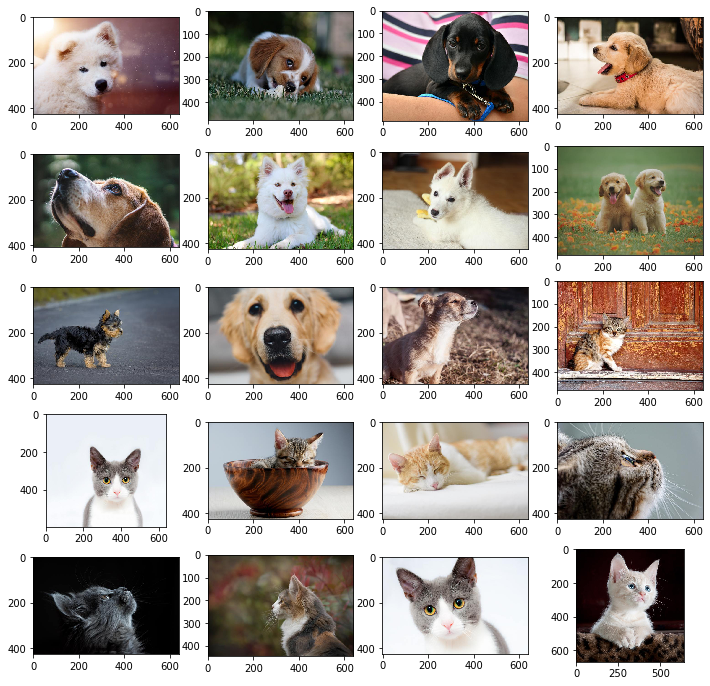

In [12]:
imgs = []
for i in range(0, 5):
    pipe_out = pipe.run()
    im, = pipe_out
    img=im.as_cpu()
    for i in img:
        imgs.append(i)
    
show_all_imgs(imgs)
    

In [13]:
from timeit import default_timer as timer

In [14]:
def speedtest(pipeclass, batch, n_threads):
    pipe = pipeclass(batch, n_threads, 0)
    pipe.build()
    # warmup
    for i in range(5):
        pipe.run()
    # test
    n_test = 1000
    t_start = timer()
    for i in range(n_test):
        pipe.run()
    t = timer() - t_start
    print("Speed: {} imgs/s".format((n_test * batch)/t))

In [15]:
class SimplePipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(SimplePipeline, self).__init__(batch_size, num_threads, device_id, seed = 12)
        self.input = ops.FileReader(file_root = "/home/lwangay/dali-data/images/", file_list="/home/lwangay/dali-data/images/file_list.txt", random_shuffle = False)
        self.decode = ops.ImageDecoder(device = 'cpu', output_type = types.RGB)

    def define_graph(self):
        jpegs, labels = self.input()
        images = self.decode(jpegs)
        return (images, labels)

In [16]:
class MixedPipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(MixedPipeline, self).__init__(batch_size, num_threads, device_id, seed = 12)
        self.input = ops.FileReader(file_root = "/home/lwangay/dali-data/images/", file_list="/home/lwangay/dali-data/images/file_list.txt", random_shuffle = False)
        self.decode = ops.ImageDecoder(device = 'mixed', output_type = types.RGB)

    def define_graph(self):
        jpegs, labels = self.input()
        images = self.decode(jpegs)
        return (images, labels)

In [20]:
speedtest(SimplePipeline, batch_size, 4)

Speed: 2811.6283931028274 imgs/s


In [21]:
speedtest(MixedPipeline, batch_size, 4)

Speed: 6935.508926791436 imgs/s


In [22]:
speedtest(ExternalSourcePipeline, batch_size, 4)

Speed: 2701.844824025157 imgs/s
